In [1]:
%load_ext autoreload
%autoreload 2

Defining a testing signal, for this I take a sinoid with a small Gaussian pulse on it (only positive)

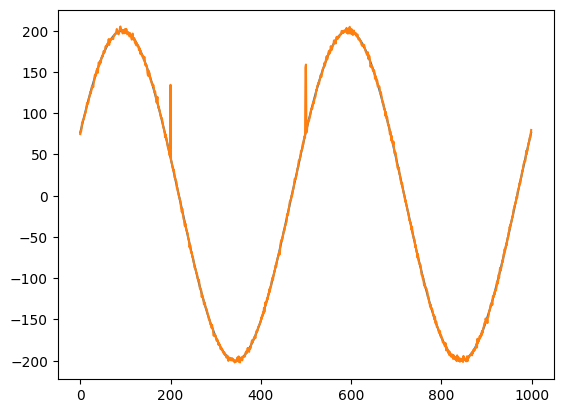

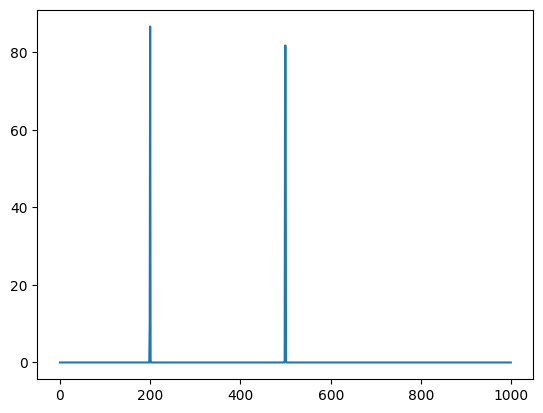

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import gausspulse


lf_amplitude=200
hf_amplitude=100
no_samples=1000
lf_frequency=2
hf_duration=10
hf_occurence=24
noise_amplitude = 2

t = np.linspace(0, 1, no_samples)   # Timevector

y_lf = lf_amplitude*np.sin(
    2*np.pi*t*lf_frequency + np.pi/8
)

_ , y_hf = gausspulse(t - 0.2, fc=2000, retenv=True)
y_hf = y_hf * hf_amplitude

_ , y_hf2 = gausspulse(t - 0.5, fc=2000, retenv=True)
y_hf2 = y_hf2 * hf_amplitude*2

y_hf = y_hf + y_hf2

# Add noise to y_lf data
y_noise = np.random.normal(0, noise_amplitude, no_samples)

plt.plot(y_lf)
plt.plot(y_hf+y_lf+y_noise)
plt.show()
plt.plot(y_hf)
plt.show()

# plt.xlim([400,600])

In [89]:
from filter_tc.timeseries import temp_comp_pf

In [90]:
input = {
    'data': y_lf,
    'name': 'test_lf',
    'unit_str': '°C',
    'fs':1
}

measurements = {
    'data': y_lf+y_hf+y_noise,
    'name': 'test_measurement',
    'unit_str' : 'microstrain',
    'fs':1
}

filtered = temp_comp_pf(
    measurements,
    input,
    num_particles=100,
    r_measurement_noise=0.01,
    q_process_noise=np.array([1e-4, 5e-1]),
    scale=1,
    loading='tension'
)

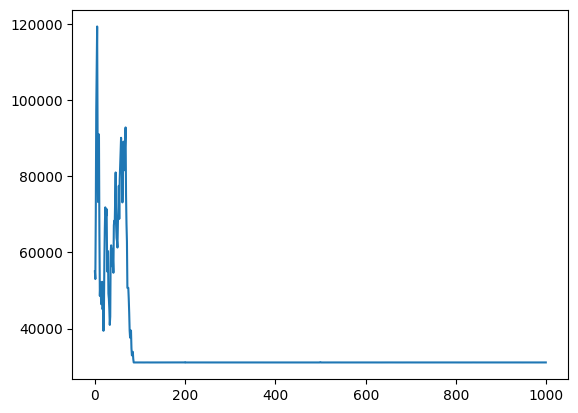

In [91]:
plt.plot(filtered['data'].flatten())

# Trying to better understand the functionality

Introducing just the ParticleFilter element. To understand how it works.

In [92]:
# NOTE: Adapt the Particle Filter to the new data problem at hand
from filter_tc.particle_filter import ParticleFilter

num_particles=100

pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=1e3,
    q_process_noise=np.array([2e-2, 1e-1]),
    scale=1e-3,
    loc=-0.1
)

In [93]:
measurements = y_lf+y_noise+y_hf
input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])

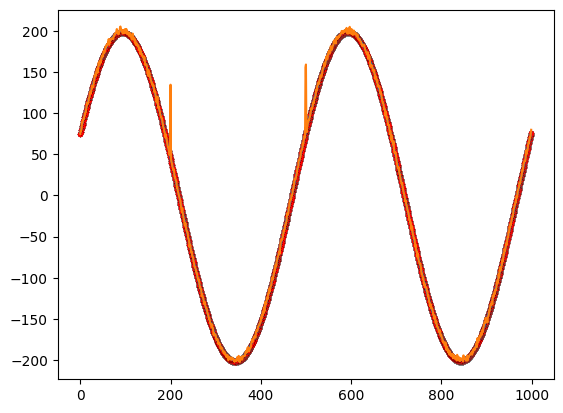

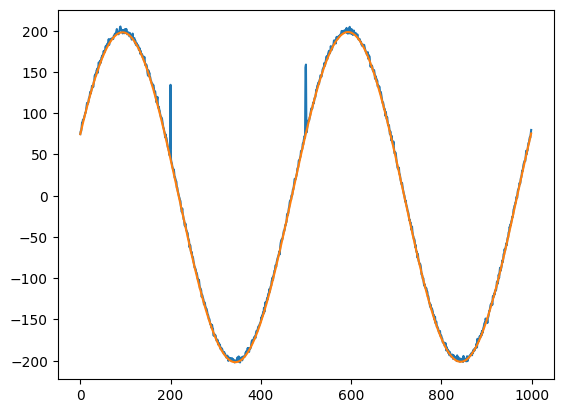

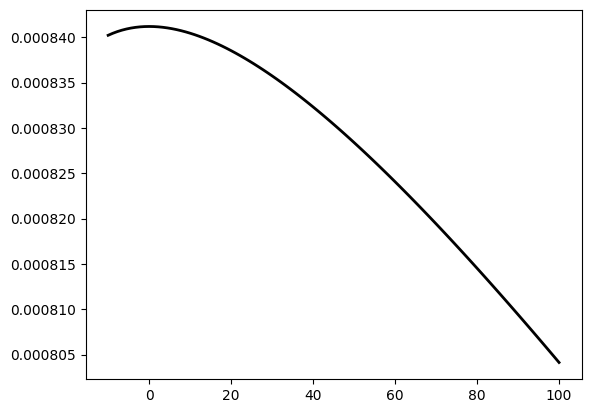

In [94]:
num_particles=1000

pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=1e3,
    q_process_noise=np.array([2e-2, 1e-10]),
    scale=1e-3,
    loc=-50.0)

loading = 'tension'
mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([0.1, 0.1]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample(loading=loading)
    #print(self.particles, self.weights)
    prediction, var = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles[:,0], marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r')

plt.plot(y_lf)
plt.plot(measurements)

# plt.ylim([-10,10])
plt.show()
plt.plot(measurements)
plt.plot(pf.predictions)

plt.show()

# plot noise ditribution
x = np.linspace(-10, 100, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')

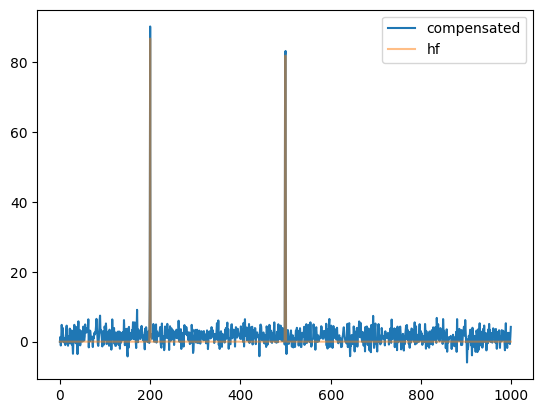

In [95]:
plt.plot(measurements-pf.predictions, label='compensated')
plt.plot(y_hf, label='hf', alpha=0.5)
plt.legend()

## Testing on a different scale influence between input and measurements

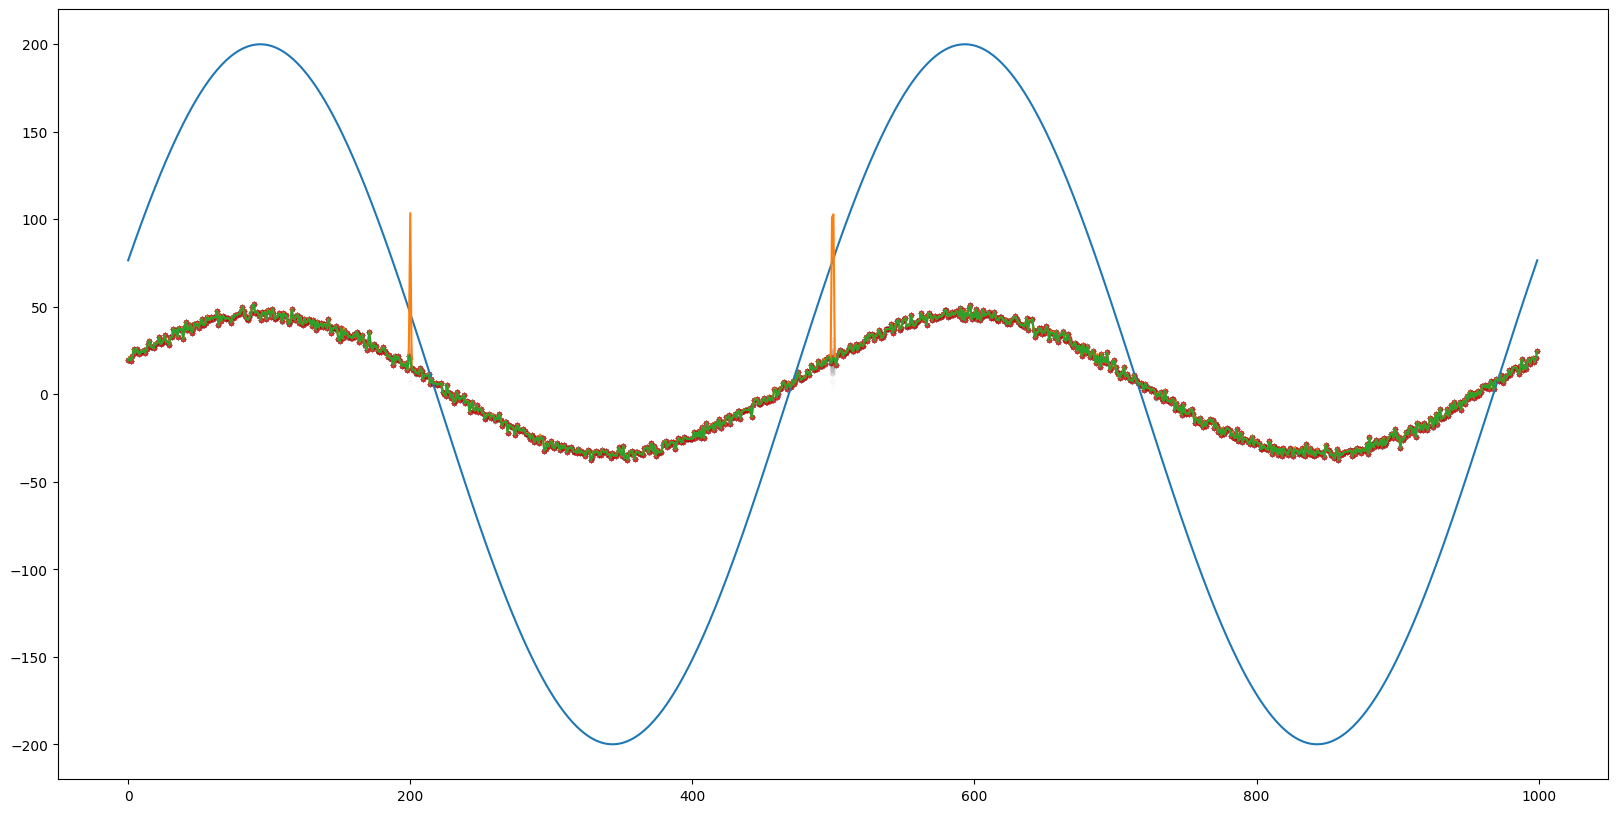

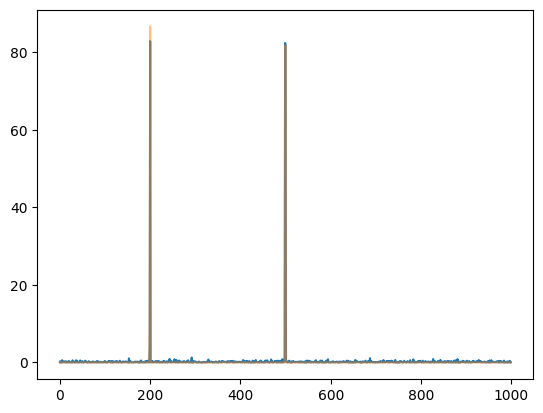

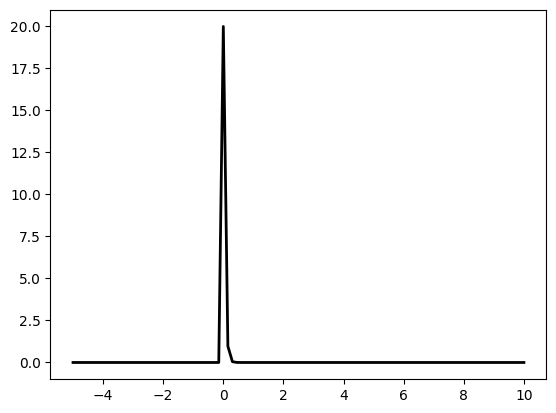

In [96]:
measurements = y_lf/5 + 6 + y_noise + y_hf


input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])

num_particles=100

pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e-2,
    q_process_noise=np.array([5, 0]),
    scale=1e-10,
    loc = 0
)

loading = 'tension'
mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([1.0, 1.0]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
plt.figure(figsize=(20,10))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample(loading=loading)
    #print(self.particles, self.weights)
    prediction, var = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles[:,0], marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r',alpha=0.5)

plt.plot(y_lf)
plt.plot(measurements)
plt.plot(pf.predictions)
plt.show()
plt.plot(measurements - pf.predictions)
plt.plot(y_hf, alpha=0.5)
plt.show()
# plot noise ditribution
x = np.linspace(-5, 10, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')

##### Filter that overly follows the measurements (no detection of event)

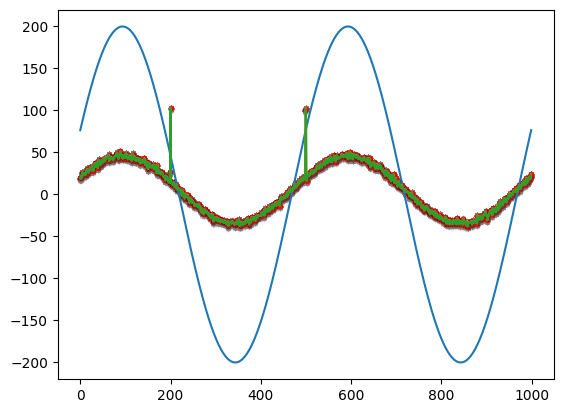

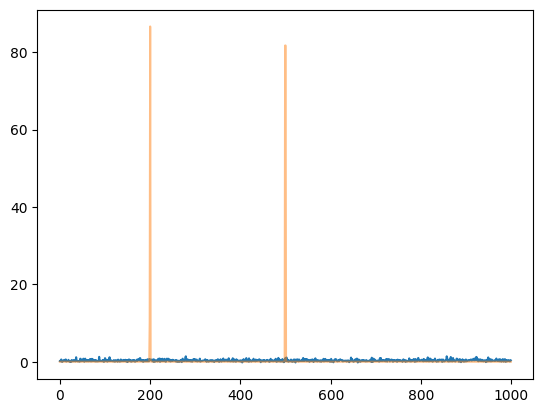

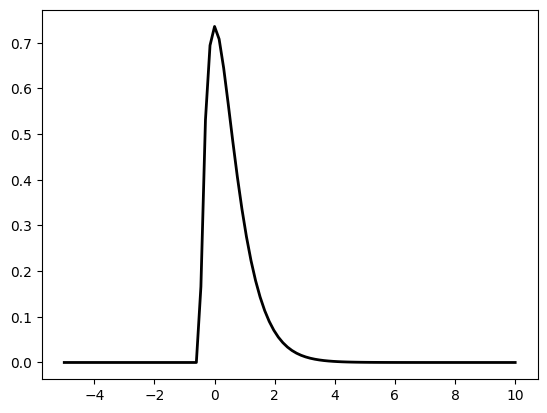

In [97]:
measurements = y_lf/5 + 6 + y_noise + y_hf


input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])

num_particles=1000

pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e-1,
    q_process_noise=np.array([1e2, 1e10]),
    scale=1e-3,
    loc = -0.5
)

loading = 'tension'
mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([1.0, 1.0]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample(loading=loading)
    #print(self.particles, self.weights)
    prediction, var = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles[:,0], marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r')

plt.plot(y_lf)
plt.plot(measurements)
plt.plot(pf.predictions)
plt.show()
plt.plot(measurements - pf.predictions)
plt.plot(y_hf, alpha=0.5)
plt.show()
# plot noise ditribution
x = np.linspace(-5, 10, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')

##### Filter that overly follows the inputs (no good smoothing of the actual measurements)

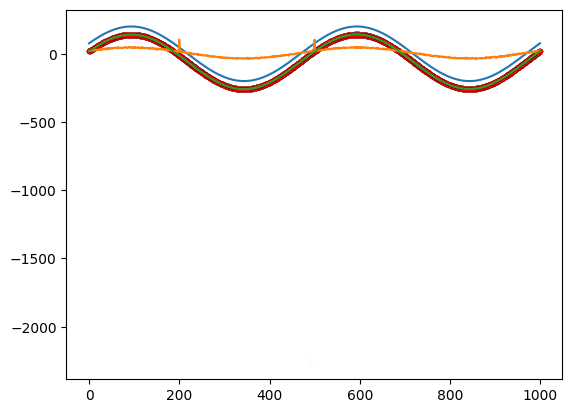

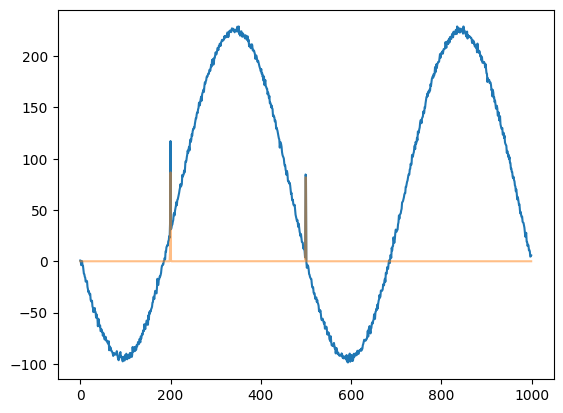

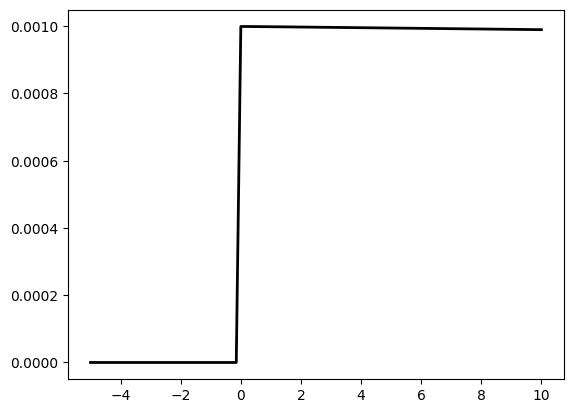

In [98]:
measurements = y_lf/5 + 6 + y_noise + y_hf

input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])

num_particles=1000

pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=1e3,
    q_process_noise=np.array([2e-2, 1e-1]),
    scale=1e-3
)

loading = 'tension'
mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([1.0, 1.0]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample(loading=loading)
    #print(self.particles, self.weights)
    prediction, var = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles[:,0], marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r')

plt.plot(y_lf)
plt.plot(measurements)
plt.plot(pf.predictions)
plt.show()
plt.plot(measurements - pf.predictions)
plt.plot(y_hf, alpha=0.5)
plt.show()
# plot noise ditribution
x = np.linspace(-5, 10, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')
# plt.ylim([-10,10])


# ParticleFilterBank

In [99]:
from filter_tc.particle_filter import ParticleFilterBank

input = {
    'data': y_lf,
    'name': 'test_lf',
    'unit_str': '°C',
    'fs':1
}


measurements = [
    {
    'data':y_lf + y_noise + y_hf,
    'name': 'test_measurement',
    'unit_str' : 'microstrain',
    'fs':1
    },
    {
        'data': y_lf+ 100 + y_noise + y_hf,
        'name': 'test_measurement_2',
        'unit_str' : 'microstrain',
        'fs':1      
    },
    {
        'data': y_lf/5 + 50 + y_noise + y_hf,
        'name': 'test_measurement_3',
        'unit_str' : 'microstrain',
        'fs':1      
    },

]

# NOTE: Change the PF settings to fit the problem
# FIXME: Maybe think of a way to automatically find these parameters?
pfb = ParticleFilterBank.from_sep005(
    measurements,
    num_particles=100,
    r_measurement_noise=1,
    q_process_noise=np.array([0.1, 1]),
    scale=1e-3)

pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e-2,
    q_process_noise=np.array([5, 0]),
    scale=1e-10,
    loc = 0
)
pfb = ParticleFilterBank.from_sep005(
    measurements,
    num_particles=1000,
    r_measurement_noise=5e-2,
    q_process_noise=np.array([5, 0]),
    scale=1e-10,
    loc = 0)

In [100]:
for pf, m in zip(pfb, measurements):
    print(f'{pf.name}: Initial value: {np.mean(pf.particles[:,0])} vs. {m["data"][0]}')

test_measurement: Initial value: 74.68289730214302 vs. 74.68226507663644
test_measurement_2: Initial value: 174.67748837365977 vs. 174.68226507663644
test_measurement_3: Initial value: 63.45045900273339 vs. 63.452915898222074


In [101]:
filtered = pfb.filter(measurements, input)

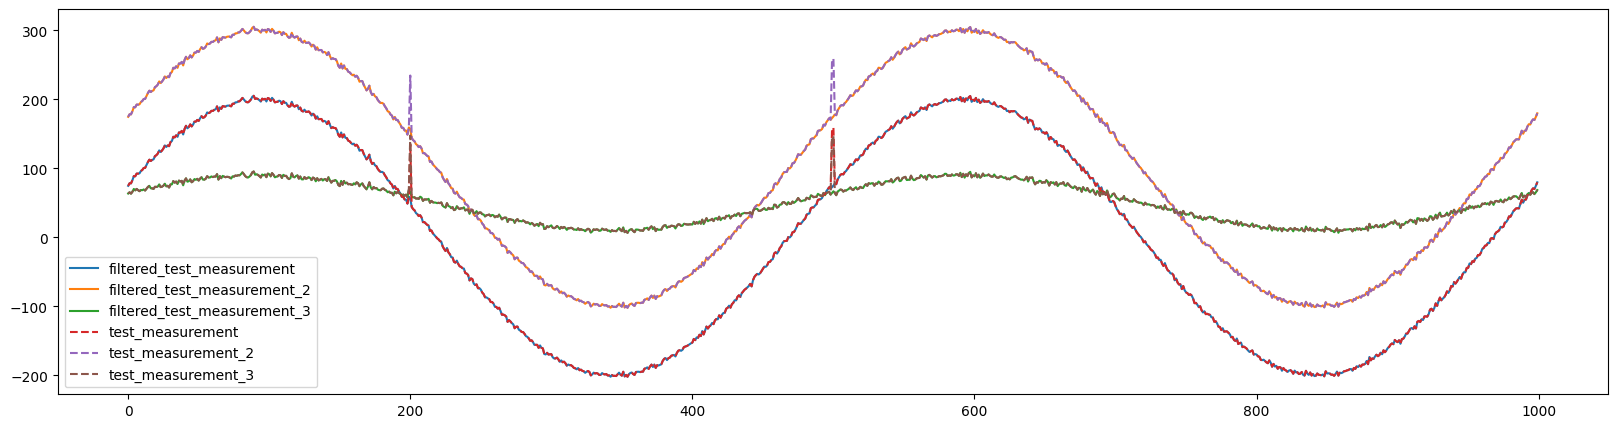

In [102]:
plt.figure(figsize=(20,5))
for fi in filtered:
    plt.plot(fi['data'], label=fi['name'])

for fi in measurements:
    plt.plot(fi['data'], label=fi['name'], linestyle='--')

#plt.plot(input['data'], label='input', linestyle='-.')
plt.legend()

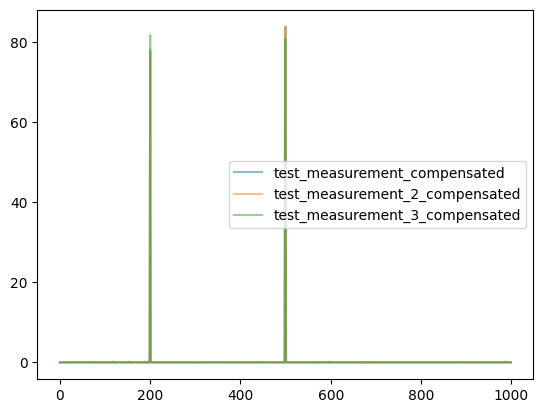

In [103]:
for i in range(len(filtered)):
    plt.plot(measurements[i]['data'] - filtered[i]['data'], label=measurements[i]['name'] + '_compensated', alpha=0.5)
plt.legend()